In [1]:
%load_ext autoreload
%autoreload 2

# Import own packages
# sys.path.append("/mnt/d/Projects/Navigation/MyCode/sydr")
import sys
sys.path.append("/mnt/c/Users/vmangr/Documents/Code/sydr")
from sydr.utils.constants import GPS_L1CA_CODE_FREQ 

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from plot import plotCorrelation, plotSignals
from misc import *
from axcoperations import loadd

import evoapproxlib as eal
from axcoperations import FullCorrelation, mult

### Create a GNSS signal

In [4]:
# Parameters
prn = 1
samplingFrequency = 5e6
cn0_target = 60
signal_bw = GPS_L1CA_CODE_FREQ # Bandwidth of the signal for CN0 to SNR computation
quantization_bits = 8

# Generate signals
# Original PRN
signal = generateGPSL1CA(prn=prn, samplingFrequency=samplingFrequency)

# Noisy signal
sigma_noise = getSigmaFromCN0(signal_power_dB=0, cn0_target_dB=cn0_target, signal_bw=signal_bw)
signal_noisy = addWhiteNoise(signal, sigma=sigma_noise)

# Quantized signal 
signal_quantized, scale_factor = quantize(signal_noisy, quantization_bits)
#signal_quantized[signal_quantized == 0] = 1

# signal[signal == -1] = -(2**quantization_bits) // 2 + 1
# signal[signal == 1] = (2**quantization_bits) // 2 - 1 
print(GPS_L1CA_CODE_FREQ)


1023000.0


26.382946097755873
27.512980629629403
26.37945644143392


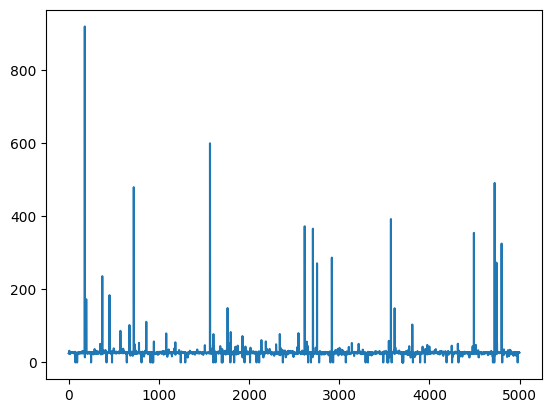

In [4]:
plt.plot(signal_quantized / signal_noisy)
print(np.median(signal_quantized / signal_noisy))
print(np.mean(signal_quantized / signal_noisy))
print(scale_factor)

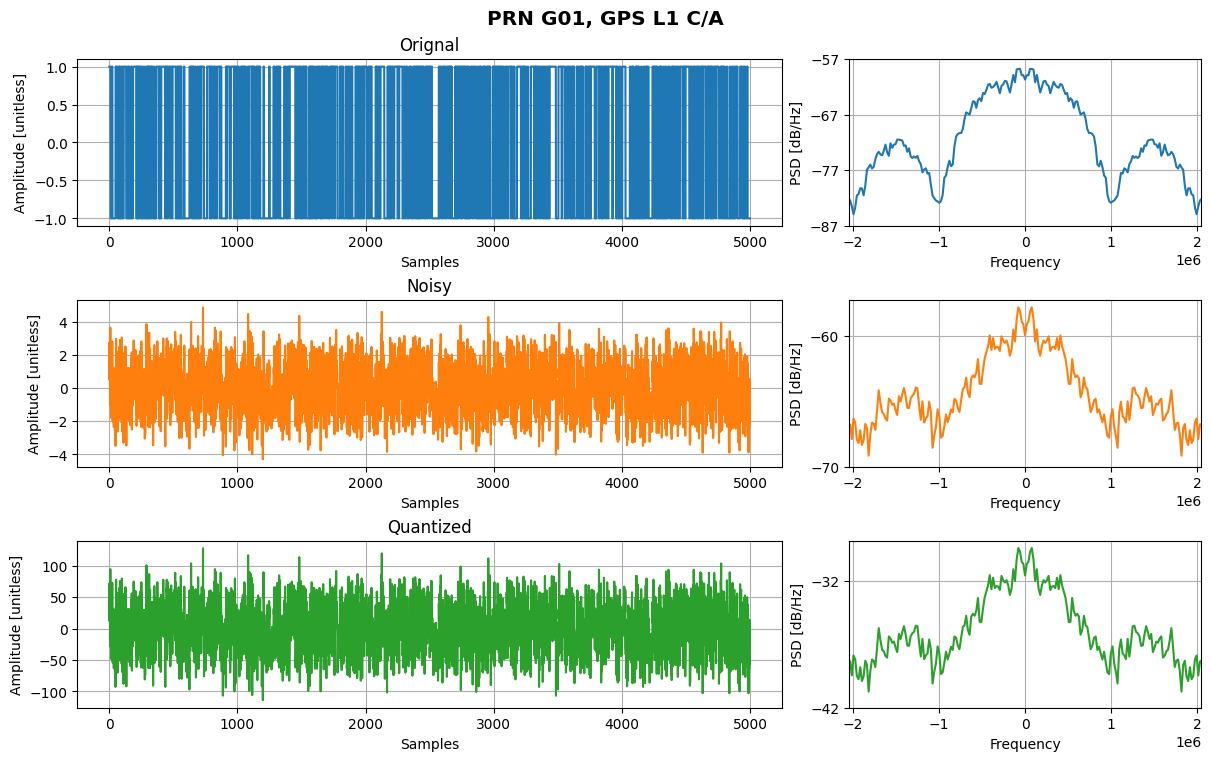

In [5]:
plotSignals({'Orignal' : signal, 'Noisy': signal_noisy, 'Quantized': signal_quantized},
            samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

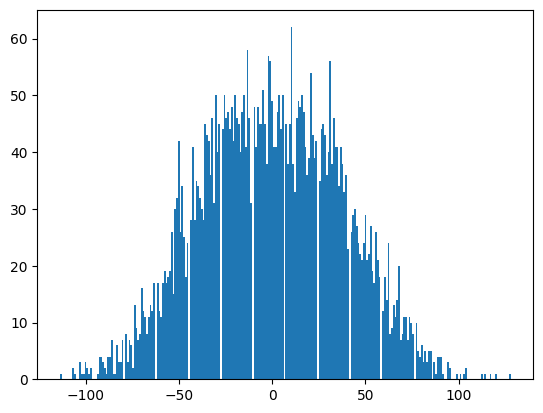

In [6]:
_ = plt.hist(signal_quantized, 2**quantization_bits)

In [7]:
print(np.unique(signal_quantized))

[-114 -107 -106 -103 -102 -101 -100  -99  -98  -97  -94  -93  -92  -91
  -90  -89  -88  -87  -86  -85  -84  -83  -82  -81  -80  -79  -78  -77
  -76  -75  -74  -73  -72  -71  -70  -69  -68  -67  -66  -65  -64  -63
  -62  -61  -60  -59  -58  -57  -56  -55  -54  -53  -52  -51  -50  -49
  -48  -47  -46  -45  -44  -43  -42  -41  -40  -39  -38  -37  -36  -35
  -34  -33  -32  -31  -30  -29  -28  -27  -26  -25  -24  -23  -22  -21
  -20  -19  -18  -17  -16  -15  -14  -13  -12  -11  -10   -9   -8   -7
   -6   -5   -4   -3   -2   -1    0    1    2    3    4    5    6    7
    8    9   10   11   12   13   14   15   16   17   18   19   20   21
   22   23   24   25   26   27   28   29   30   31   32   33   34   35
   36   37   38   39   40   41   42   43   44   45   46   47   48   49
   50   51   52   53   54   55   56   57   58   59   60   61   62   63
   64   65   66   67   68   69   70   71   72   73   74   75   76   77
   78   79   80   81   82   83   84   85   87   88   89   90   91   92
   94 

### Perform correlation

In [8]:
# Correlate
signal_corr, signal_lags = FullCorrelation(signal, signal)
signal_noisy_corr, signal_noisy_lags = FullCorrelation(signal, signal_noisy)

In [9]:
signal_quantized_corr, signal_quantized_lags = FullCorrelation(signal, signal_quantized)

In [33]:
#signal_axc_corr, signal_axc_lags = correlation(signal, signal_quantized, axc_mult=mult)
#signal_axc_corr, signal_axc_lags = correlate(signal, signal_quantized, axc_mult=eal.mul8s_1KVA.calc)
signal_axc_corr, signal_axc_lags = FullCorrelation(signal, signal_quantized, axc_mult=eal.mul8s_1L12.calc, axc_corr=-16)

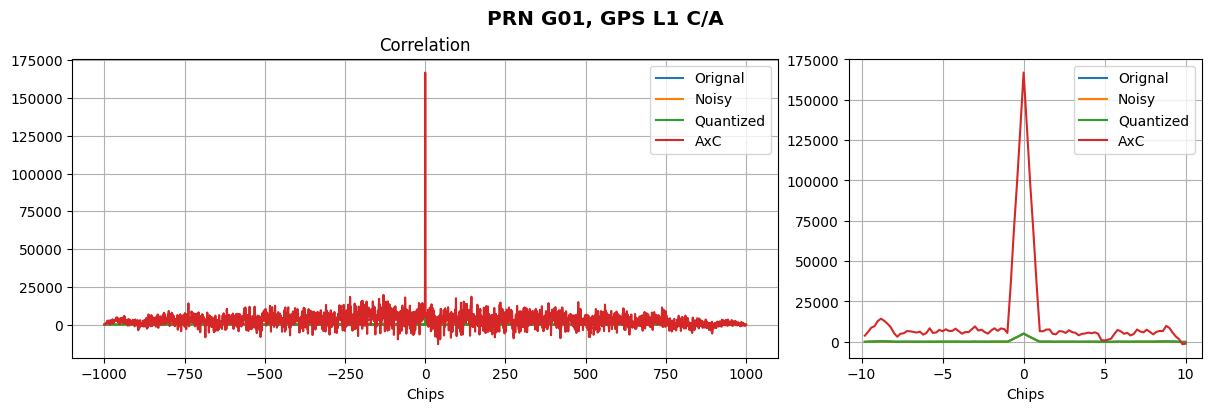

In [28]:
from plot import plotCorrelation
plotCorrelation({
'Orignal' : (signal_corr, signal_lags), 
'Noisy': (signal_noisy_corr, signal_noisy_lags),
'Quantized': (signal_quantized_corr / scale_factor, signal_quantized_lags),
'AxC': (signal_axc_corr / scale_factor, signal_axc_lags)}, 
samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

In [17]:
# Find SNR loss
snr_signal_original = getPostCorrelationSNR(signal_corr, samplingFrequency)
snr_signal_noisy = getPostCorrelationSNR(signal_noisy_corr, samplingFrequency)
snr_signal_quantized = getPostCorrelationSNR(signal_quantized_corr, samplingFrequency)
snr_signal_axc = getPostCorrelationSNR(signal_axc_corr, samplingFrequency)

print(f"Original : {snr_signal_original:.5f}") 
print(f"Noisy    : {snr_signal_noisy:.5f}") 
print(f"Quantized: {snr_signal_quantized:.5f}") 
print(f"AxC      : {snr_signal_axc:.5f}") 

/mnt/c/Users/vmangr/Documents/Code/axcgnss/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/c/Users/vmangr/Documents/Code/axcgnss/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'signal_noisy_corr' is not defined

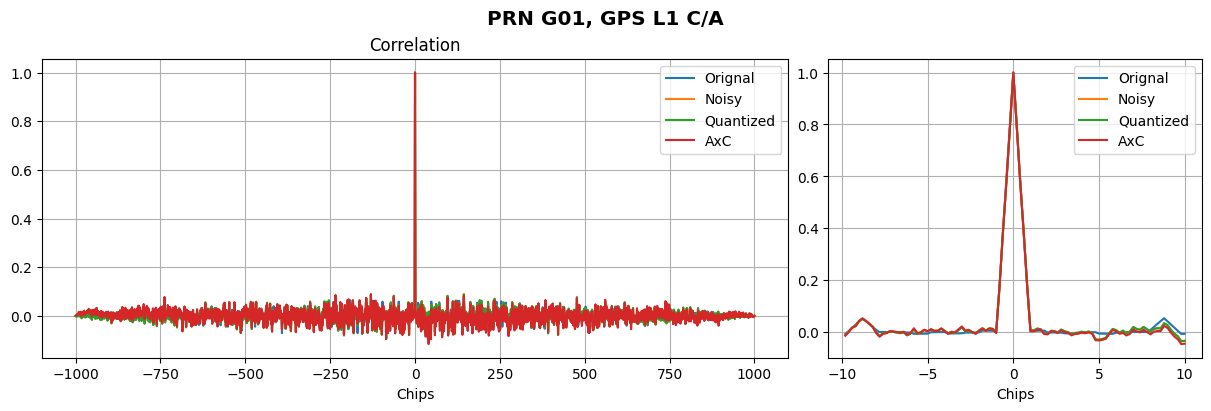

In [34]:
from plot import plotCorrelation
plotCorrelation({
'Orignal' : (signal_corr / np.max(signal_corr), signal_lags), 
'Noisy': (signal_noisy_corr / np.max(signal_noisy_corr), signal_noisy_lags),
'Quantized': (signal_quantized_corr / np.max(signal_quantized_corr), signal_quantized_lags),
'AxC': (signal_axc_corr / np.max(signal_axc_corr), signal_axc_lags)}, 
samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

## Partial correlation

In [31]:
def GenerateDelayedReplicas(signal, correlator_delays):

    # codeStep = GPS_L1CA_CODE_FREQ / self.rfSignal.samplingFrequency
    replicas = {}
    for delay in correlator_delays: 
        replicas[delay] = np.roll(signal, delay)

    return replicas


def PartialCorrelation(array1, replicas, axc_mult=None, axc_corr=0):

    N = len(array1)

    corr = np.zeros(len(replicas.keys()))
    lags = np.zeros(len(replicas.keys()))
    idx = 0
    for delay, array2 in replicas.items():
        if axc_mult==None:
            corr[idx] = np.sum(array1 * array2)
            lags[idx] = delay
        else:
            correlation = 0
            for i in range(0, N):
                correlation += axc_mult(array1[i], array2[i]) + axc_corr
            corr[idx] = correlation
            lags[idx] = delay
        idx += 1

    return corr, lags

# ========================

prn = 1
samplingFrequency = 5e6
cn0_target = 60
signal_bw = GPS_L1CA_CODE_FREQ # Bandwidth of the signal for CN0 to SNR computation
quantization_bits = 8

# Generate signals
# Original PRN
signal = generateGPSL1CA(prn=prn, samplingFrequency=samplingFrequency)

# Noisy signal
sigma_noise = getSigmaFromCN0(signal_power_dB=0, cn0_target_dB=cn0_target, signal_bw=signal_bw)
signal_noisy = addWhiteNoise(signal, sigma=sigma_noise)

# Quantized signal 
signal_quantized, scale_factor = quantize(signal_noisy, quantization_bits)

# Correlations
delay_range = int(samplingFrequency*1e-3)
chip_size = int(np.ceil(GPS_L1CA_CODE_FREQ / samplingFrequency))
correlator_delays = range(-delay_range+2*chip_size, delay_range-2*chip_size, 1)
replicas = GenerateDelayedReplicas(signal, correlator_delays)

signal_corr, signal_lags = PartialCorrelation(signal, replicas)
signal_noisy_corr, signal_noisy_lags = PartialCorrelation(signal_noisy, replicas)
signal_quantized_corr, signal_quantized_lags = PartialCorrelation(signal_quantized, replicas)
signal_axc_corr, signal_axc_lags = PartialCorrelation(signal_quantized, replicas, axc_mult=eal.mul8s_1L12.calc, axc_corr=0)


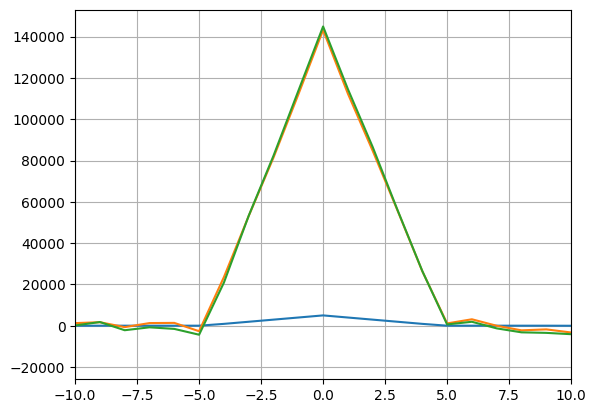

In [32]:

plt.figure()
plt.plot(signal_lags, signal_corr)
plt.plot(signal_quantized_lags, signal_quantized_corr)
plt.plot(signal_axc_lags, signal_axc_corr)
plt.xlim((-10, 10))
plt.grid()

In [33]:
signal_corr

array([2952., 1928.,  904., ...,   20.,  904., 1928.])

In [34]:
# Find SNR loss
snr_signal_original = getPostCorrelationSNR(signal_corr, samplingFrequency)
snr_signal_noisy = getPostCorrelationSNR(signal_noisy_corr, samplingFrequency)
snr_signal_quantized = getPostCorrelationSNR(signal_quantized_corr, samplingFrequency)
snr_signal_axc = getPostCorrelationSNR(signal_axc_corr, samplingFrequency)

print(f"Original : {snr_signal_original:.5f}") 
print(f"Noisy    : {snr_signal_noisy:.5f}") 
print(f"Quantized: {snr_signal_quantized:.5f}") 
print(f"AxC      : {snr_signal_axc:.5f}") 

Original : 7.00313
Noisy    : 7.11877
Quantized: 7.11822
AxC      : 7.10312


(0.0, 100.0)

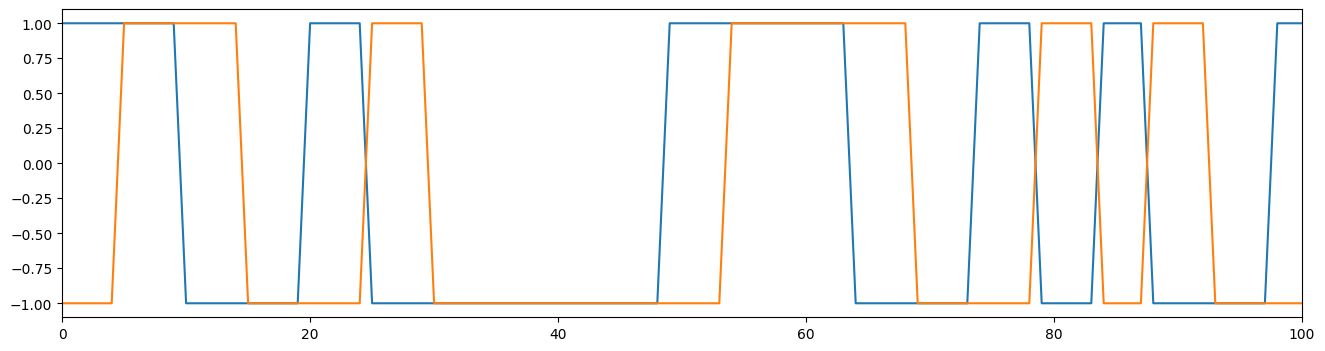

In [49]:
plt.figure(figsize=(16,4))
plt.plot(signal)
plt.plot(replicas[-10])
plt.xlim((0, 100))

# MISC

## 8x8 signed

In [37]:
import ealwrapper as ealw

df = ealw.getMultipliersEAL('8x8_signed')
df.sort_values(by=['PDK45_PWR'], ascending=False)

,NAME,MAE_PERCENT,MAE,WCE_PERCENT,WCE,WCRE_PERCENT,EP_PERCENT,MRE_PERCENT,MSE,PDK45_PWR,PDK45_AREA,PDK45_DELAY
0,mul8s_1KV6,0.0000,0.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.425,729.8,1.48
5,mul8s_1KV8,0.0018,1.2,0.0076,5.0,500.0,50.00,0.28,3.8,0.422,711.0,1.48
6,mul8s_1KV9,0.0064,4.2,0.0260,17.0,1700.0,68.75,0.90,34.0,0.410,685.2,1.47
12,mul8s_1KVA,0.0190,12.0,0.0750,49.0,4900.0,81.25,2.53,248.0,0.391,641.1,1.51
1,mul8s_1KVM,0.0490,32.0,0.2000,128.0,100.0,49.80,2.40,2731.0,0.369,652.8,1.37
7,mul8s_1KVP,0.0510,33.0,0.2100,137.0,900.0,74.80,2.73,2746.0,0.363,635.0,1.37
10,mul8s_1KVQ,0.0560,36.0,0.2500,161.0,3300.0,84.18,3.64,2872.0,0.351,599.8,1.36
4,mul8s_1L2J,0.0810,53.0,0.3900,255.0,300.0,74.61,4.41,5462.0,0.301,558.9,1.36
11,mul8s_1KX5,0.1500,101.0,0.6900,449.0,6500.0,91.89,8.93,19690.0,0.289,543.0,1.33
2,mul8s_1KXF,0.3400,224.0,1.3700,896.0,700.0,87.16,15.72,95576.0,0.237,482.4,1.19


Text(0.5, 1.0, '8x8 signed')

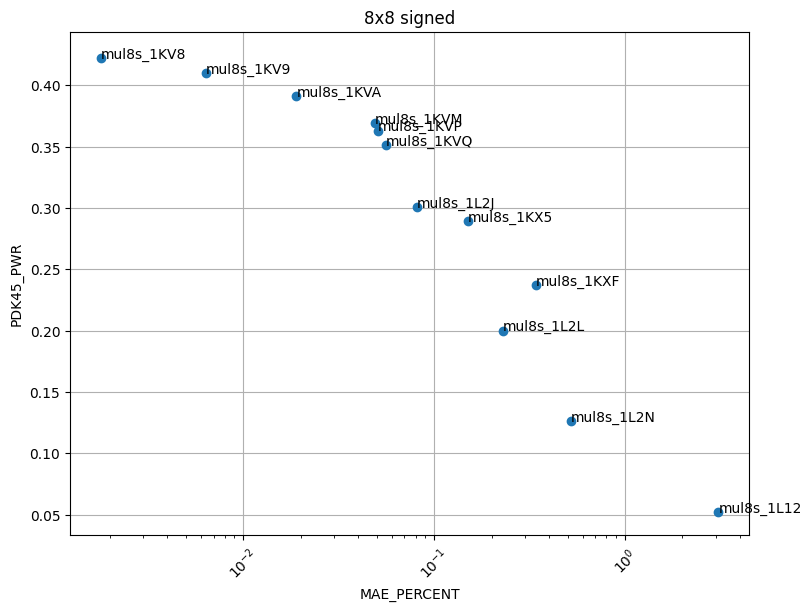

In [21]:
ealw.plotKPI(df, 'MAE_PERCENT', 'PDK45_PWR', log_x=True)
plt.title("8x8 signed")

mul8s_1KV6 0.0 0.0
mul8s_1KVM -0.25 0.0
mul8s_1KXF -1.75 0.0
mul8s_1L12 -15.75 0.0
mul8s_1L2J -32256.75 -193.0
mul8s_1KV8 1.25 0.5
mul8s_1KV9 4.25 4.0
mul8s_1KVP 2.25 2.0
mul8s_1L2L -31747.75 -435.0
mul8s_1L2N -30735.75 -840.0
mul8s_1KVQ 8.25 8.0
mul8s_1KX5 16.25 16.0
mul8s_1KVA 12.25 12.0


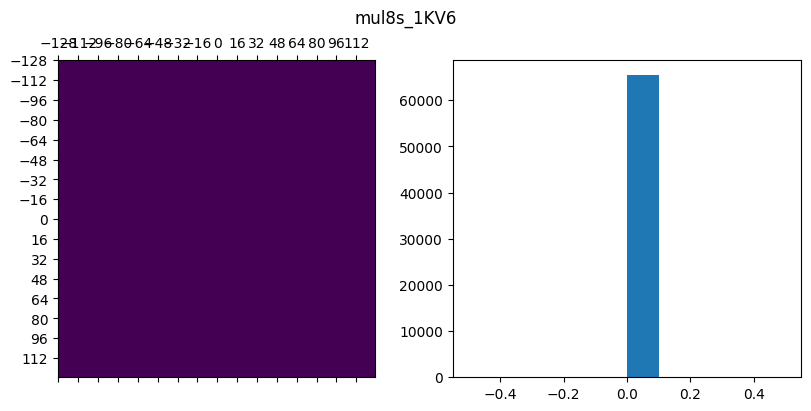

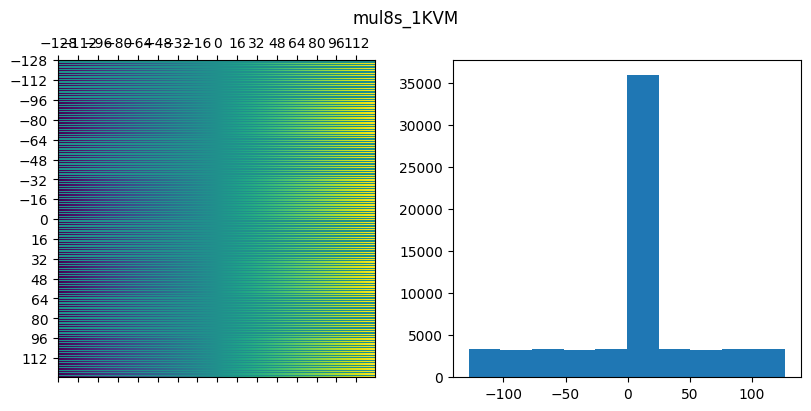

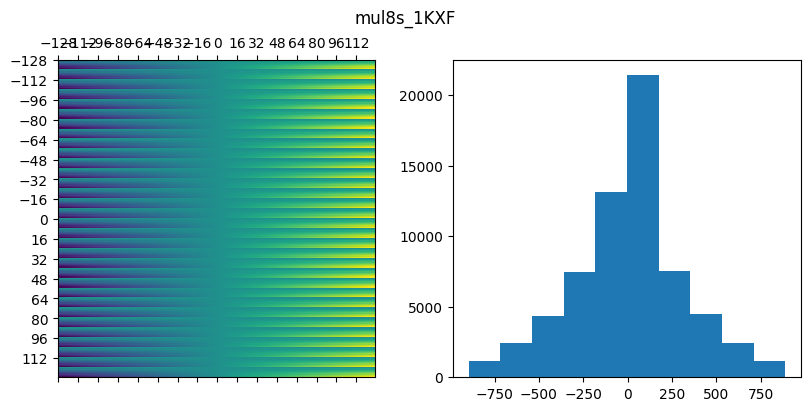

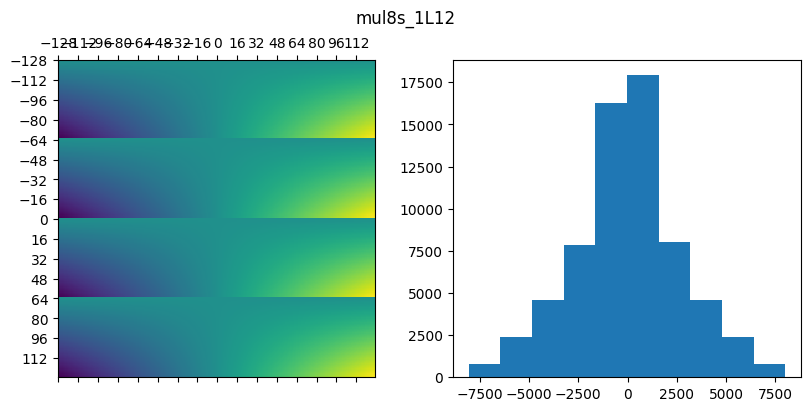

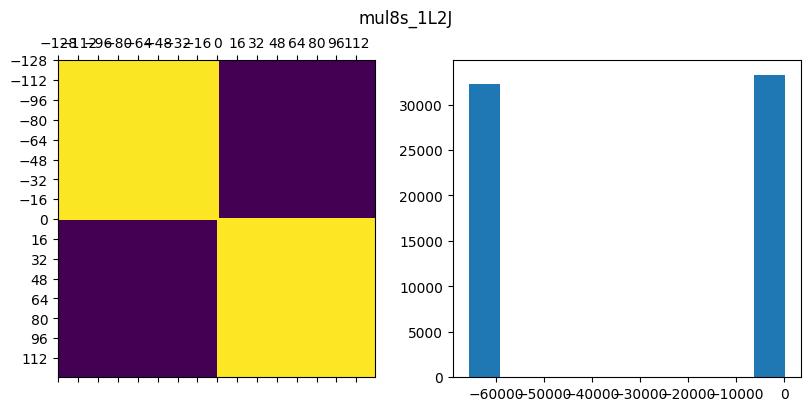

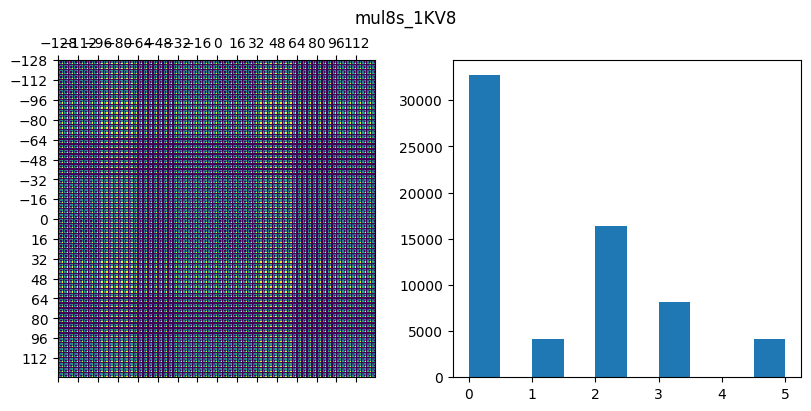

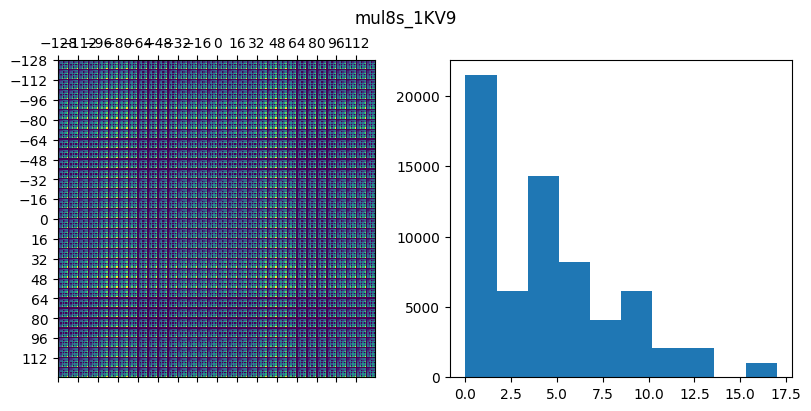

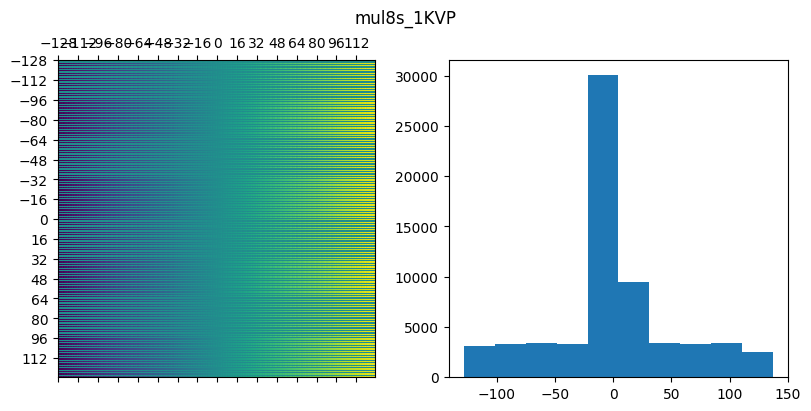

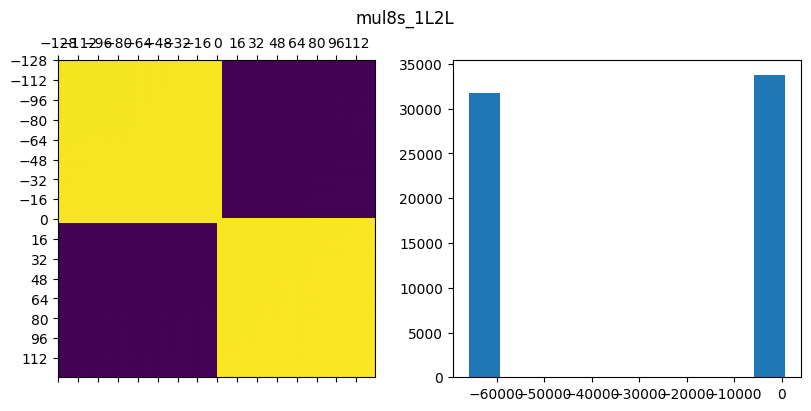

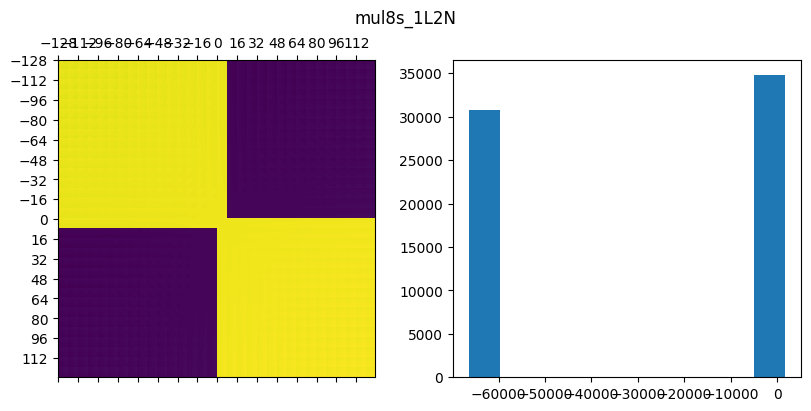

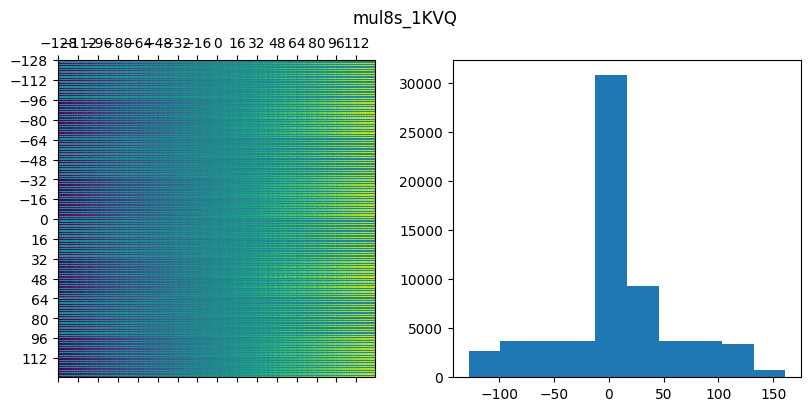

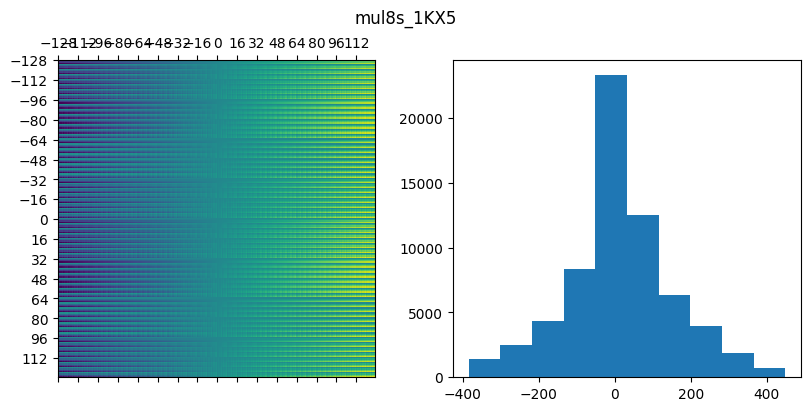

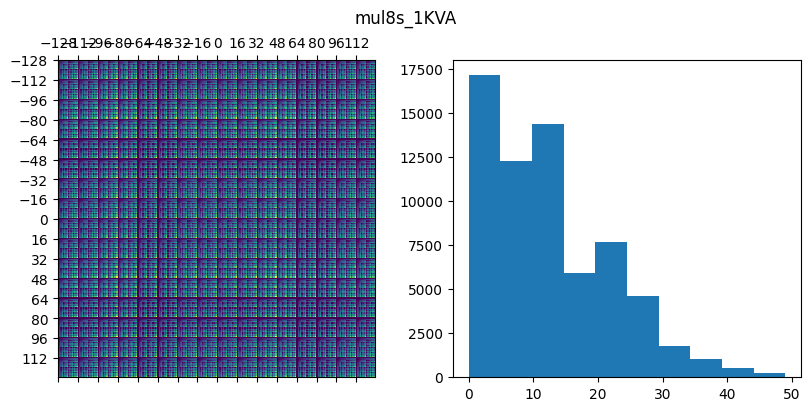

In [22]:
import numpy as np
from matplotlib.ticker import MultipleLocator
from axcoperations import lcadd
import evoapproxlib as eal

axc_bits = 1 # Lower bits approximated
bits = 8
max_value = 2**bits // 2
i_range = np.arange(-max_value, max_value, dtype=np.int16)
j_range = np.arange(-max_value, max_value, dtype=np.int16)
exact_results = np.zeros((2**bits, 2**bits))
axc_results = np.zeros((2**bits, 2**bits))

for name, module in eal.multipliers['8x8_signed'].items():
    for i in i_range:
        for j in j_range:
            axc_mult = getattr(module, 'calc')
            #axc_results[i+max_value,j+max_value] = lcadd(i, j, axc_bits)
            axc_results[i+max_value,j+max_value] = axc_mult(i, j)
            exact_results[i+max_value,j+max_value] = i * j
            
    error = exact_results - axc_results
    minError = np.min(error)
    maxError = np.max(error)
    print(f"{name} {np.mean(error)} {np.median(error)}")

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
    fig.suptitle(f"{name}")
    plot = axs[0].matshow(error, extent=(-max_value-0.5, max_value-0.5, max_value-0.5, -max_value-0.5))
    axs[0].xaxis.set_major_locator(MultipleLocator(max_value/8))
    axs[0].yaxis.set_major_locator(MultipleLocator(max_value/8))
    axs[1] = plt.hist(error.flatten())

## 12x12 signed

In [39]:
import ealwrapper as ealw

df = ealw.getMultipliersEAL('12x12_signed')
df = df.sort_values(by=['PDK45_PWR'], ascending=False)
df


,NAME,MAE_PERCENT,MAE,WCE_PERCENT,WCE,WCRE_PERCENT,EP_PERCENT,MRE_PERCENT,MSE,PDK45_PWR,PDK45_AREA,PDK45_DELAY
0,mul12s_2PP,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00000,0.000000e+00,1.210,1650.5,2.33
1,mul12s_2PQ,0.000001,0.2,0.000006,1.0,100.0,25.00,0.00047,2.000000e-01,1.205,1644.4,2.34
7,mul12s_2PR,0.000007,1.2,0.000030,5.0,500.0,50.00,0.00230,3.800000e+00,1.200,1631.8,2.32
8,mul12s_2PS,0.000025,4.2,0.000100,17.0,1700.0,68.75,0.00760,3.400000e+01,1.189,1605.9,2.32
9,mul12s_2PT,0.000073,12.0,0.000290,49.0,4900.0,81.25,0.02100,2.480000e+02,1.168,1564.2,2.30
2,mul12s_2QD,0.003100,512.0,0.012000,2048.0,100.0,49.99,0.22000,6.990510e+05,1.093,1528.0,2.24
3,mul12s_2QE,0.003100,512.0,0.012000,2049.0,300.0,62.49,0.22000,6.990520e+05,1.091,1524.3,2.26
10,mul12s_2QH,0.003100,524.0,0.013000,2145.0,9700.0,90.61,0.25000,7.000700e+05,1.055,1443.6,2.22
6,mul12s_34K,0.005100,853.0,0.024000,4095.0,300.0,74.98,0.41000,1.398102e+06,0.965,1385.4,2.13
11,mul12s_2R5,0.009200,1540.0,0.037000,6209.0,6500.0,92.17,0.65000,4.893930e+06,0.948,1395.2,2.12


Text(0.5, 1.0, '12x12 signed')

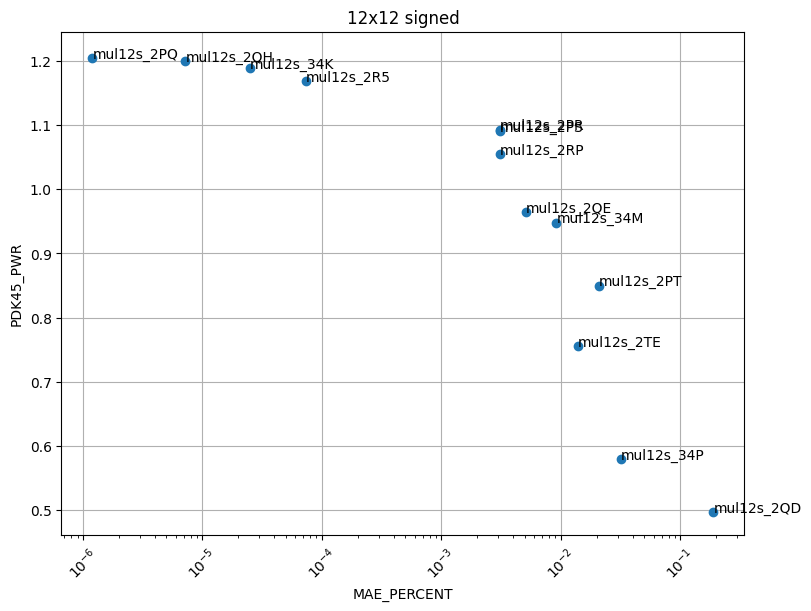

In [24]:
ealw.plotKPI(df, 'MAE_PERCENT', 'PDK45_PWR', log_x=True)
plt.title("12x12 signed")

## 16x16 signed

In [40]:
import ealwrapper as ealw

df = ealw.getMultipliersEAL('16x16_signed')
df = df.sort_values(by=['PDK45_PWR'], ascending=False)
df
df['NAME'].to_list()

['mul16s_HG4',
 'mul16s_GQU',
 'mul16s_GQV',
 'mul16s_HF7',
 'mul16s_GRU',
 'mul16s_GSM',
 'mul16s_HG8',
 'mul16s_HFB',
 'mul16s_GV3']

Text(0.5, 1.0, '16x16 signed')

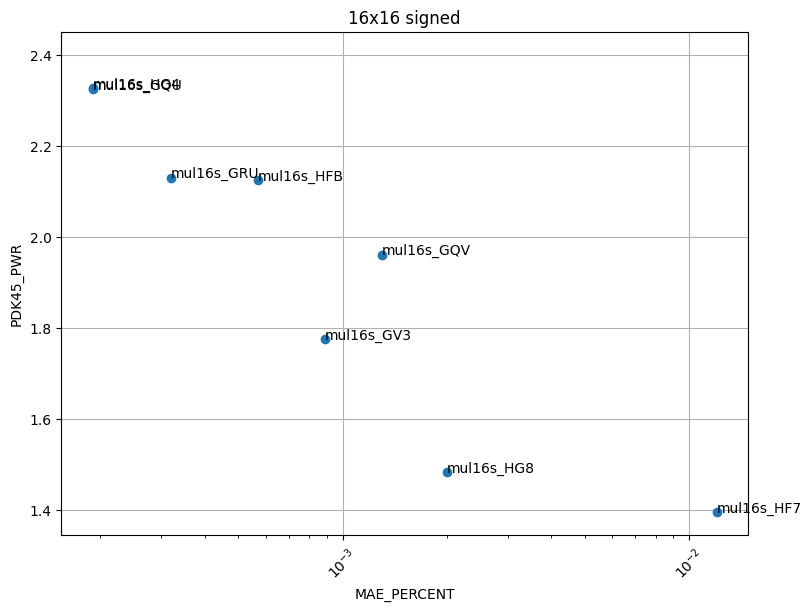

In [26]:
ealw.plotKPI(df, 'MAE_PERCENT', 'PDK45_PWR', log_x=True)
plt.title("16x16 signed")